In [ ]:
from zipfile import ZipFile, BadZipFile
import os
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import requests
from io import BytesIO
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path

In [ ]:
#Descargar Dataset
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

--2024-10-11 02:17:05--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.104.73, 16.15.177.69, 3.5.29.247, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.104.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip  100%[===================>]  18.01G  51.2MB/s    in 5m 52s  

2024-10-11 02:22:57 (52.4 MB/s) - ‘coco_train2017.zip’ saved [19336861798/19336861798]

--2024-10-11 02:22:57--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.219.129, 52.217.36.196, 3.5.7.144, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.219.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[=============

In [ ]:
#Unzip
from zipfile import ZipFile, BadZipFile
import os

def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)

        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)

    except BadZipFile as e:
        print("Error:", e)


extract_train_path = "./coco_train2017"
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"

extract_zip_file(extract_train_path)
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

In [ ]:
from collections import defaultdict
import json
import numpy as np

class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)
        self.cat_dict = {}
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}

        for ann in coco['annotations']:
            self.annIm_dict[ann['image_id']].append(ann)
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license

#links image IDs to their corresponding image information.
    def get_imgIds(self):
        return list(self.im_dict.keys())

#takes im_ids, which is a list of image IDs, as an input parameter and returns the list of annotation IDs.
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]

#retrieve information associated with a given list of annotation IDs as the input parameter
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]

#returns the list of categories associated with the given class_ids.
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]

#returns a list of licenses corresponding to each image ID in the list im_ids.
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [ ]:
coco_annotations_file="/content/coco_ann2017/annotations/instances_val2017.json"
coco_images_dir="/content/coco_val2017/val2017"
# to access and manipulate the annotations and images in the COCO dataset.
coco= COCOParser(coco_annotations_file, coco_images_dir)

Tamaño: (640, 533)
Tipo de archivo: JPEG
¿Es RGB?: Sí
Tamaño: (640, 549)
Tipo de archivo: JPEG
¿Es RGB?: Sí
Tamaño: (640, 426)
Tipo de archivo: JPEG
¿Es RGB?: Sí
Tamaño: (640, 428)
Tipo de archivo: JPEG
¿Es RGB?: Sí


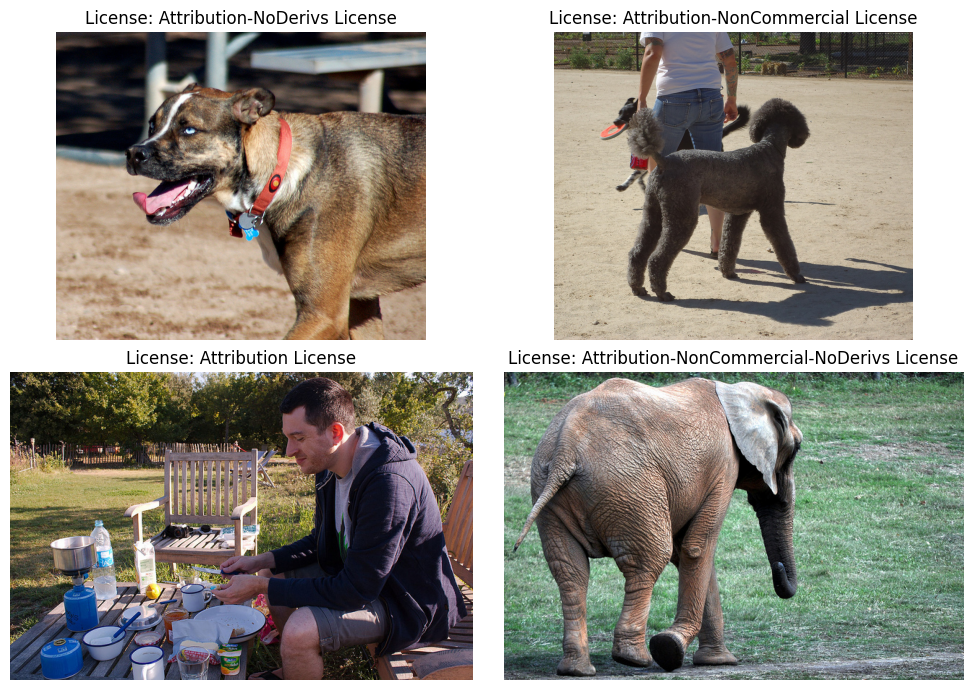

In [ ]:
#load the dataset and visualize the objects in the images by displaying the bounding boxes around them along with their respective class names
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]

img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]

ann_ids = coco.get_annIds(selected_img_ids)
im_licenses = coco.get_imgLicenses(selected_img_ids)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
ax = ax.ravel()

for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:

        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        license = coco.get_imgLicenses(im)[0]["name"]

    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {license}")
    print(f"Tamaño: {image.size}")  # Tamaño en (ancho, alto)
    print(f"Tipo de archivo: {image.format}")  # Formato del archivo
    print(f"¿Es RGB?: {'Sí' if image.mode == 'RGB' else 'No'}")  # Verifica si es RGB

plt.tight_layout()
plt.show()

#VGG16

In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio


Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
Found existing installation: torchvision 0.19.1+cu121
Uninstalling torchvision-0.19.1+cu121:
  Successfully uninstalled torchvision-0.19.1+cu121
Found existing installation: torchaudio 2.4.1+cu121
Uninstalling torchaudio-2.4.1+cu121:
  Successfully uninstalled torchaudio-2.4.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO


# Definición de la red VGG16 "from scratch"
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Bloque 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),  # 1000 clases para ImageNet
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Preprocesamiento para la imagen
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Cargar una imagen de la base COCO

# total_images = len(coco.get_imgIds()) # total number of images
# sel_im_idxs = np.random.permutation(total_images)[:1]

# img_ids = coco.get_imgIds()
# selected_img_ids = [img_ids[i] for i in sel_im_idxs]
# print(selected_img_ids)
# ann_ids = coco.get_annIds(selected_img_ids)
# im_licenses = coco.get_imgLicenses(selected_img_ids)

# ax = ax.ravel()
# image = Image.open(f"{coco_images_dir}/{str(214205).zfill(12)}.jpg")
# ann_ids = coco.get_annIds(im)
# annotations = coco.load_anns(ann_ids)


# Aplicar preprocesamiento
# img_tensor = preprocess(image).unsqueeze(0)  # Añadir dimensión para batch

# Instanciar la red y pasar la imagen por ella
# model = VGG16()
# output = model(img_tensor)

# print(f"Salida de la red: {output.shape}")
